In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [10]:
df = pd.read_csv("telco.csv")
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df = df.dropna(subset=["TotalCharges"])

df = df.drop(columns=["customerID"])
df["Churn"] = df["Churn"].map({"No":0, "Yes":1})

In [11]:
X = df.drop(columns=["Churn"])
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


In [12]:
num_cols = X.select_dtypes(include=['int64','float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ])


In [13]:
def eval_model(pipe, model_name):
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:,1]

    print(f"====== {model_name} ======")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1:", f1_score(y_test, y_pred))
    print("AUC:", roc_auc_score(y_test, y_prob))
    print("\n", classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


====== Logistic Regression ======
Accuracy: 0.8038379530916845
Precision: 0.6484848484848484
Recall: 0.5721925133689839
F1: 0.6079545454545454
AUC: 0.8359290473207676

               precision    recall  f1-score   support

           0       0.85      0.89      0.87      1033
           1       0.65      0.57      0.61       374

    accuracy                           0.80      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.80      0.80      1407



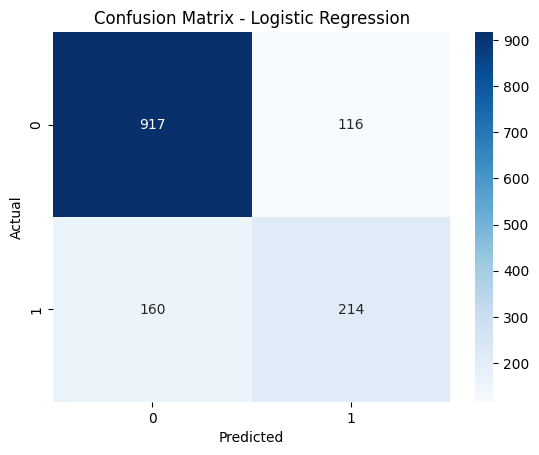

In [14]:
lr_pipe = Pipeline([
    ('preprocess', preprocessor),
    ('model', LogisticRegression(max_iter=1000))
])

eval_model(lr_pipe, "Logistic Regression")


====== Decision Tree ======
Accuracy: 0.7903340440653873
Precision: 0.616519174041298
Recall: 0.5588235294117647
F1: 0.5862552594670407
AUC: 0.8231709211009934

               precision    recall  f1-score   support

           0       0.85      0.87      0.86      1033
           1       0.62      0.56      0.59       374

    accuracy                           0.79      1407
   macro avg       0.73      0.72      0.72      1407
weighted avg       0.78      0.79      0.79      1407



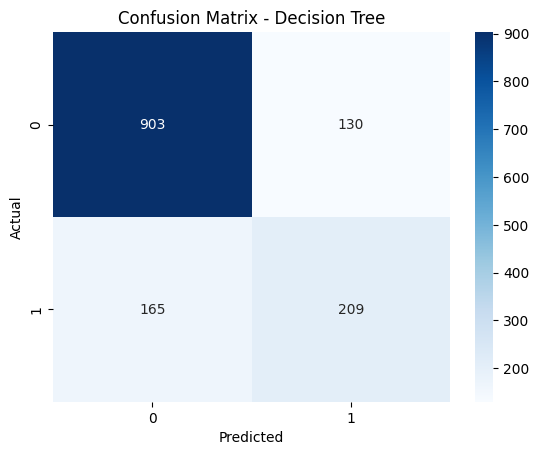

In [15]:
dt_pipe = Pipeline([
    ('preprocess', preprocessor),
    ('model', DecisionTreeClassifier(max_depth=6, random_state=42))
])

eval_model(dt_pipe, "Decision Tree")


====== Random Forest ======
Accuracy: 0.7839374555792467
Precision: 0.6232394366197183
Recall: 0.4732620320855615
F1: 0.5379939209726444
AUC: 0.8120395918642033

               precision    recall  f1-score   support

           0       0.82      0.90      0.86      1033
           1       0.62      0.47      0.54       374

    accuracy                           0.78      1407
   macro avg       0.72      0.68      0.70      1407
weighted avg       0.77      0.78      0.77      1407



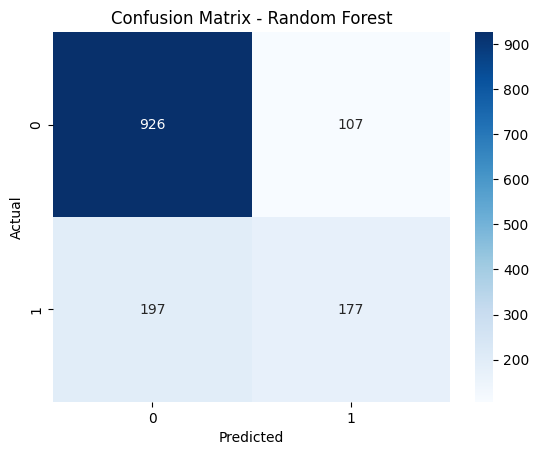

In [16]:
rf_pipe = Pipeline([
    ('preprocess', preprocessor),
    ('model', RandomForestClassifier(
        n_estimators=200,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ))
])

eval_model(rf_pipe, "Random Forest")


====== XGBoost ======
Accuracy: 0.7668798862828714
Precision: 0.5649717514124294
Recall: 0.5347593582887701
F1: 0.5494505494505495
AUC: 0.8018789052186923

               precision    recall  f1-score   support

           0       0.83      0.85      0.84      1033
           1       0.56      0.53      0.55       374

    accuracy                           0.77      1407
   macro avg       0.70      0.69      0.70      1407
weighted avg       0.76      0.77      0.76      1407



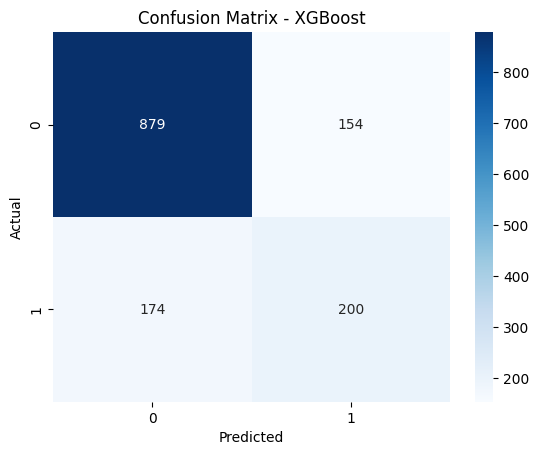

In [17]:
xgb_pipe = Pipeline([
    ('preprocess', preprocessor),
    ('model', xgb.XGBClassifier(
        n_estimators=200,
        eval_metric='logloss',
        random_state=42
    ))
])

eval_model(xgb_pipe, "XGBoost")


In [18]:
models = {
    "Logistic": lr_pipe,
    "DecisionTree": dt_pipe,
    "RandomForest": rf_pipe,
    "XGBoost": xgb_pipe
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    prob = model.predict_proba(X_test)[:,1]

    results.append([
        name,
        accuracy_score(y_test, pred),
        precision_score(y_test, pred),
        recall_score(y_test, pred),
        f1_score(y_test, pred),
        roc_auc_score(y_test, prob)
    ])

pd.DataFrame(results,
             columns=["Model","Accuracy","Precision","Recall","F1","AUC"])


,Model,Accuracy,Precision,Recall,F1,AUC
0,Logistic,0.803838,0.648485,0.572193,0.607955,0.835929
1,DecisionTree,0.790334,0.616519,0.558824,0.586255,0.823171
2,RandomForest,0.783937,0.623239,0.473262,0.537994,0.812040
3,XGBoost,0.766880,0.564972,0.534759,0.549451,0.801879
